In [1]:
import torch
import json
from tqdm import tqdm

from pprint import pprint

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset, Features, Value
from torch.utils.data import DataLoader

checkpoint = "Salesforce/codet5p-2b"
device = "cuda:7" # for GPU usage or "cpu" for CPU usage
commit = "0d030d0077331c69e011d3401f783254b8201330"

/data/dok/viola/envs/env_vuln/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer_lt = AutoTokenizer.from_pretrained(checkpoint, 
                                          truncation_side='left', 
                                          padding_side='right') # padding should only occur in targets

tokenizer_rt = AutoTokenizer.from_pretrained(checkpoint, 
                                          truncation_side='right', 
                                          padding_side='right')

In [3]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint,
                                              torch_dtype=torch.float32, #float16
                                              trust_remote_code=True,
                                              revision=commit,
                                              ).to(device)

In [4]:
secc_features = Features({'file_change_id': Value('string'),
                          'programming_language': Value('string'),
                            'prompt': Value('string'),
                            'target_vul': Value('string'),
                            'target_patch': Value('string'),
                            'remainder': Value('string') })
ds = load_dataset("csv", 
                    data_files="../lm_eval/data/small_local_changes.csv", 
                    name="SecC", 
                    delimiter=',',
                    skiprows=1,
                    column_names=['file_change_id', 'programming_language','prompt','target_vul','target_patch','remainder'],
                    features=secc_features)


#ds = ds['train'].train_test_split(test_size=0.3)

Found cached dataset csv (/data/dok/viola/cache/datasets/csv/SecC-234a6d0b3e51ce2e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 1/1 [00:00<00:00, 335.33it/s]


In [5]:
def replace_none(example):
    for c in ['prompt', 'target_patch', 'target_vul', 'remainder']:
        example[c] = "" if example[c] == None else example[c]
    return example

ds = ds.map(replace_none)


Loading cached processed dataset at /data/dok/viola/cache/datasets/csv/SecC-234a6d0b3e51ce2e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-203d6d5ea4cd384b.arrow


In [6]:
from functools import partial


MAX_LENGTH = 256

def preprocess_function(examples, use_vulnerability=False):
    # uses patches as default targets. 
    target = "target_vul" if use_vulnerability else "target_patch"
    extended_targets = [p+r for p,r in zip(examples[target], examples["remainder"])]

    model_inputs = tokenizer_lt(
        text = examples["prompt"],
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
        )
    target_len = [len(inp_ids) for inp_ids in tokenizer_rt(text = examples[target])['input_ids']]
    model_inputs["target_len"] = torch.tensor(target_len)[:,None]
    # equal sized labels, padded with remaining code
    # TODO use max patch length as MAX_LEN
    # truncation -> right
    labels = tokenizer_rt(text = extended_targets, 
                              truncation=True, 
                              padding="max_length", 
                              max_length=MAX_LENGTH,
                              return_tensors="pt")
    
    model_inputs["labels"] = labels["input_ids"]
    #model_inputs["labels"] = [
    #            [(l if l != tokenizer_rt.pad_token_id else -100) for l in label] for label in model_inputs["labels"]
    #        ]
    return model_inputs

# keep file_change_id and programming_language
ds_vul_preprocessed = ds.map(partial(preprocess_function, use_vulnerability=True), batched=True, remove_columns=['prompt', 'target_patch', 'target_vul', 'remainder'])
ds_benign_preprocessed = ds.map(preprocess_function, batched=True, remove_columns=['prompt', 'target_patch', 'target_vul', 'remainder'])

Map:   0%|          | 0/1167 [00:00<?, ? examples/s]

Map:  86%|████████▌ | 1000/1167 [00:10<00:01, 97.60 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (336108 > 2048). Running this sequence through the model will result in indexing errors
Loading cached processed dataset at /data/dok/viola/cache/datasets/csv/SecC-234a6d0b3e51ce2e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-0c0e296be8d8f9aa.arrow


In [7]:
def print_seq_probs(seq_ids, probs, seq_lengths):
    batch = []
    seq = ""
    for input_sentence, input_probs, len in zip(seq_ids, probs, seq_lengths):
        text_sequence = []
        for token, p in list(zip(input_sentence, input_probs))[:len]:
            if token not in tokenizer_rt.all_special_ids:
                t_str = tokenizer_rt.decode(token)
                text_sequence.append((t_str, p.item()))
                seq += t_str
        batch.append(text_sequence)
    print(seq, "~"*20)
    pprint(batch)


def debug_print(seq_ids, probs, seq_lengths, predictions, pred_probs):
    print("~"*20, "\nTARGET: ~~~~~~~~~~~~~~~~~~~")
    print_seq_probs(seq_ids, probs, seq_lengths)
    print("~"*20, "\nPREDICTED: ~~~~~~~~~~~~~~~~~~~")
    print_seq_probs(predictions, pred_probs, seq_lengths)
    

In [8]:
from typing import Union, List


model.config.decoder_start_token_id = tokenizer_rt.pad_token_id
model.config.pad_token_id = tokenizer_rt.pad_token_id



def compute_prob(tokenized_sample: torch.Tensor, debug: bool = False):
    with torch.no_grad():
        input_ids = torch.tensor(tokenized_sample['input_ids']).unsqueeze(0).to(model.device)
        attention_mask = torch.tensor(tokenized_sample['attention_mask']).unsqueeze(0).to(model.device)
        labels = torch.tensor(tokenized_sample['labels']).unsqueeze(0).to(model.device)
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
    probs = torch.softmax(outputs.logits, dim=-1)

    preds = outputs.logits.argmax(axis=-1)
    pred_probs = torch.gather(probs, 2, preds[:, :, None]).squeeze(-1)

    gen_probs= torch.gather(probs, 2, labels[:, :, None]).squeeze(-1)
    
    if debug:
        debug_print(labels, gen_probs, tokenized_sample['target_len'], preds, pred_probs)

    return {'max_preds': preds.tolist(), 
            'pred_probs': pred_probs.tolist(),
            'pred_prob': torch.mean(pred_probs).tolist(),
            'gen_probs': gen_probs.tolist(), 
            'gen_prob':torch.mean(gen_probs).tolist(),
            'seq_len': tokenized_sample['target_len'],
            'programming_language': tokenized_sample['programming_language'],
            'id': tokenized_sample['file_change_id'],
            }

def compute_prob_from_str(prompt: str, target: str, debug = False):
    
    inputs_prompt = tokenizer_lt(prompt, 
                            max_length=MAX_LENGTH,
                            truncation = True,
                            return_tensors="pt").input_ids.to(device)
    inputs_seq = tokenizer_rt(target, 
                            return_tensors="pt").input_ids.to(device)
    seq_len = inputs_seq.shape[1]
    input_ids = torch.cat([inputs_prompt, inputs_seq], 1)[:, -MAX_LENGTH:]
    with torch.no_grad():
            outputs = model(inputs_prompt, labels=inputs_seq) # teacher forcing -> Problem???
    #log_probs = torch.log_softmax(outputs.logits, dim=-1)
    probs = torch.softmax(outputs.logits, dim=-1)

    preds = outputs.logits.argmax(axis=-1)
    pred_probs = torch.gather(probs, 2, preds[:, :, None]).squeeze(-1)

    gen_probs= torch.gather(probs, 2, inputs_seq[:, :, None]).squeeze(-1)
    
    if debug:
        debug_print(inputs_seq, gen_probs)

    return {'max_preds': preds, 
            'pred_probs': pred_probs,
            'pred_prob': torch.mean(pred_probs),
            'gen_probs': gen_probs, 
            'gen_prob':torch.mean(gen_probs)
       
            }





def get_probs(sample, debug=False):
    prompt, target_vul, target_benign = sample['prompt'], sample['target_vul'], sample['target_patch']
    
    probs_vul = compute_prob_from_str(prompt, target_vul, debug)
    probs_benign = compute_prob_from_str(prompt, target_benign, debug)
    return {'vul': probs_vul,
            'benign': probs_benign}
    
#get_probs(ds['train'][3], debug=True)

#dataloader_benign = DataLoader(ds_benign_preprocessed['train'], batch_size=16)
#for batch in dataloader_benign:
#    compute_prob(batch)
results = []
counter = 0
for sample in tqdm(ds_benign_preprocessed['train']):
    results.append(compute_prob(sample))

#compute_prob(ds_benign_preprocessed['train'][38], debug=True)
with open("benign_probs.json", "w") as out_file:
     json_string = json.dumps(results)
     out_file.write(json_string)

100%|██████████| 1167/1167 [02:39<00:00,  7.30it/s]


In [9]:
results = []

for sample in tqdm(ds_vul_preprocessed['train']):
    results.append(compute_prob(sample))

#compute_prob(ds_benign_preprocessed['train'][38], debug=True)
with open("vuln_probs.json", "w") as out_file:
     json_string = json.dumps(results)
     out_file.write(json_string)

100%|██████████| 1167/1167 [02:40<00:00,  7.27it/s]


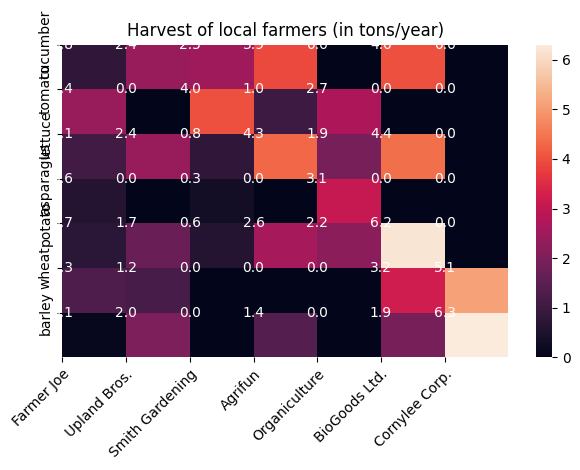

In [12]:
import numpy as np

import seaborn as sns

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_v = results[0]
sequences = ["vulnerable", "benign", "predicted"]
v_probs = sample_v['gen_probs'][0]
p_probs = sample_v['pred_probs'][0]



vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
sns.heatmap(harvest)
#im = ax.imshow(harvest)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(farmers)), labels=farmers)
ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

In [11]:
logprobs_vul = []
logprobs_benign = []
for sample in tqdm((ds['test'])):
    # skip samples with empty entries
    if (sample['prompt'] and sample['target_vul']and sample['target_patch']):
        #print(id)
        probs = get_probs(sample)
        logprobs_vul.append(probs['vul'].item())
        logprobs_benign.append(probs['benign'].item())

print('Vul:', sum(logprobs_vul)/len(logprobs_vul))
print('Patch:', sum(logprobs_benign)/len(logprobs_benign))
    

KeyError: 'test'

Vul: -0.9650103652532748
Patch: -0.8153926904488774

In [ ]:
dataloader = torch.utils.data.DataLoader(ds_preprocessed['train'], batch_size=32)

nlls = []

with torch.no_grad():
    for batch in dataloader:
        batch = {k: torch.stack(v, 1).to(device) for k, v in batch.items()}
        batch['decoder_input_ids'] = batch['input_ids'].clone()
        batch['decoder_attention_mask'] = batch['attention_mask'].clone()

        
        #outputs = model.generate(**batch, max_length=15)
        
        outputs = model(**batch)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)

nlls

[tensor(12.0133, device='cuda:7'),
 tensor(13.0264, device='cuda:7'),
 tensor(11.9090, device='cuda:7'),
 tensor(12.7067, device='cuda:7'),
 tensor(12.4534, device='cuda:7'),
 tensor(11.8607, device='cuda:7'),
 tensor(12.2405, device='cuda:7'),
 tensor(12.0835, device='cuda:7'),
 tensor(12.0819, device='cuda:7'),
 tensor(11.8817, device='cuda:7'),
 tensor(12.4014, device='cuda:7'),
 tensor(12.0080, device='cuda:7'),
 tensor(11.6789, device='cuda:7'),
 tensor(11.8240, device='cuda:7'),
 tensor(11.9567, device='cuda:7'),
 tensor(11.6667, device='cuda:7'),
 tensor(11.4663, device='cuda:7'),
 tensor(11.8686, device='cuda:7'),
 tensor(12.7551, device='cuda:7'),
 tensor(11.7515, device='cuda:7'),
 tensor(13.7884, device='cuda:7'),
 tensor(12.0905, device='cuda:7')]

In [ ]:

ds_tokenized = ds.map(lambda example: tokenizer(example["prompt"],
                                            text_target=example["target_patch"],
                                            max_length=256,
                                            truncation=True,
                                            padding=True,
                                            return_tensors="pt"),
                                            batched=True,
                                            remove_columns=['prompt', 'remainder','target_patch']) 

#ds_tokenized['train'][0]
ds_tokenized["train"].column_names

['file_change_id', 'target_vul', 'input_ids', 'attention_mask', 'labels']

In [ ]:
ds_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#def add_decoder_input(example):
#    example['decoder_input_ids']=example['input_ids'].clone()
#    return example

#ds_tokenized = ds_tokenized.map(add_decoder_input)



dataloader = torch.utils.data.DataLoader(ds_tokenized['train'], batch_size=32)

nlls = []

with torch.no_grad():
    for batch in dataloader:

        batch['decoder_input_ids'] = batch['input_ids'].clone()
        batch['decoder_attention_mask'] = batch['attention_mask'].clone()
        batch = {k: v.to(device) for k, v in batch.items()}
        
        #outputs = model.generate(**batch, max_length=15)
        
        outputs = model(**batch)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss
        nlls.append(neg_log_likelihood)

nlls

ValueError: Expected input batch_size (8192) to match target batch_size (2720).

In [ ]:
tokenized_ds = ds.map(preprocess_function, batched=True)

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [ ]:
#encodings = tokenizer(ds["test"]["prompt"], return_tensors="pt")

max_length = model.config.n_positions
stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())